In [2]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%load_ext autoreload
%autoreload 1

Author: Andrew Tarzia

Date Created: 05 Aug 2018

Distributed under the terms of the MIT License.

# Notebook to analyse all enzymes used in ZIF-8 experiments using BRENDA database

TODO:
- add license
- modifications
    - introduce exposure consideration
        - get another method for calculating exposure without structure?
    - generalise code to multiple target residues ("targ = convert_to_one_letter_code_sing('target_res')" needs to act on a list

In [3]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Alphabet import IUPAC
from rdkit.Chem.Draw import IPythonConsole  # to show molecules in notebook
import time
import numpy as np
import pandas as pd
# ensure cpickle usage
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors3D import NPR1, NPR2, PMI1, PMI2, PMI3
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Geometry import rdGeometry
from rdkit.Chem import PyMol
from rdkit import Geometry
import tempfile
%aimport pi_fn
%aimport parameters
%aimport BRENDA_IO
%aimport SABIO_IO
%aimport rdkit_functions
%aimport ellipsoid
%aimport DB_functions
%aimport CHEBI_IO
%aimport BKMS_IO
%aimport KEGG_IO
%aimport Uniprot_IO
%aimport PUBCHEM_IO
%aimport rxn_syst

# Calculate pI of all sequences in EC No. used in literature
## Produces distribution for each EC No.

## Notes:
### Biopython:
- pK values and the methods are taken from::
    * Bjellqvist, B.,Hughes, G.J., Pasquali, Ch., Paquet, N., Ravier, F.,
    Sanchez, J.-Ch., Frutiger, S. & Hochstrasser, D.F.
    The focusing positions of polypeptides in immobilized pH gradients can be
    predicted from their amino acid sequences. Electrophoresis 1993, 14,
    1023-1031.
    * Bjellqvist, B., Basse, B., Olsen, E. and Celis, J.E.
    Reference points for comparisons of two-dimensional maps of proteins from
    different human cell types defined in a pH scale where isoelectric points
    correlate with polypeptide compositions. Electrophoresis 1994, 15, 529-539.

|  AA | pKa  |
|-----|------|
| ASP | 4.05 |
| GLU | 4.45 |
| HIS | 5.98 |
| CYS | 9.00 |
| TYR | 10.0 |
| LYS | 10.0 |
| ARG | 12.0 |
| N-terminus | 7.50 |
| N-terminus : GLU | 7.7 |
| N-terminus : VAL | 7.44 |
| N-terminus : THR | 6.82 |
| N-terminus : PRO | 8.36 |
| N-terminus : SER | 6.93 |
| N-terminus : MET | 7.00 |
| N-terminus : ALA | 7.59 |
| C-terminus | 3.55 |
| C-terminus : ASP | 4.55 |
| C-terminus : GLU | 4.75 |

- with the above pKas and the data set in Tash's paper (DOI:) we apply a pI cut off = XX.


### Modified pIs:
- assuming sequence only and therefore cannot use DSSP to calculate exposure

In [3]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/sequence_db/bio_min_dataset/'
output_dir = database_directory

In [4]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_set = {
    # EC : species list
    '1.11.1.5': ['equus caballus', ],
    '1.11.1.6': ['bos taurus', ],
    '1.11.1.7': ['armoracia rusticana', ],
    '1.9.3.1': ['equus caballus', ],
    '1.1.5.2': ['none', ],
    '3.5.1.5': ['canavalia ensiformis'],
    '1.1.3.4': ['aspergillus niger'],
    '1.13.12.4': ['none'],
    '3.2.1.26': ['none'],
    '3.1.1.3': ['thermomyces lanuginosus', 'alcaligenes sp.',
                'pseudomonas fluorescens',
                'rhizomucor miehei', 'candida antarctica',
                'aspergillus niger'],
    '3.1.1.6': ['lactobacillus acidophilus'],
    '3.5.1.11': ['none'],
    }

In [5]:
# get input FASTA file names
database_names = []
for i in glob.glob(database_directory+"*fasta"):
    if "_mod" not in i:
        database_names.append(i)
database_names = sorted(database_names)
print('databases:')
for i in database_names:
    print('--', i.replace(database_directory, ''))

# prepare output CSV file
redo_pi = input('redo pI calculation (True = yes, False = no)')
if redo_pi == 'True':
    redo_pi = True
    pi_fn.prepare_out_csv(output_dir, param_dict)
    # fix formatting of FASTA files to match BIOPYTHON readable
    pi_fn.fix_fasta(database_names)

databases:
-- 1_11_1_5__BRENDA_sequences.fasta
-- 1_11_1_6__BRENDA_sequences.fasta
-- 1_11_1_7__BRENDA_sequences.fasta
-- 1_13_12_4__BRENDA_sequences.fasta
-- 1_1_3_4__BRENDA_sequences.fasta
-- 1_1_5_2__BRENDA_sequences.fasta
-- 1_9_3_1__BRENDA_sequences.fasta
-- 3_1_1_3__BRENDA_sequences.fasta
-- 3_1_1_6__BRENDA_sequences.fasta
-- 3_2_1_26__BRENDA_sequences.fasta
-- 3_5_1_11__BRENDA_sequences.fasta
-- 3_5_1_5__BRENDA_sequences.fasta
redo pI calculation (True = yes, False = no)False


calculate all pIs for target EC sequences
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_5__BRENDA_sequences.fasta
--- finished 2220 sequences in 0.69 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_6__BRENDA_sequences.fasta
--- finished 22068 sequences in 7.67 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta
--- finished 16288 sequences in 4.23 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_13_12_4__BRENDA_sequences.fasta
--- finished 379 sequences in 0.12 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_1_3_4__BRENDA_sequences.fasta
--- finished 36 sequences in 0.02 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_1_5_2__BRENDA_sequences.fasta
--- finished 1765 sequences in 0.67 seconds ---
plot d

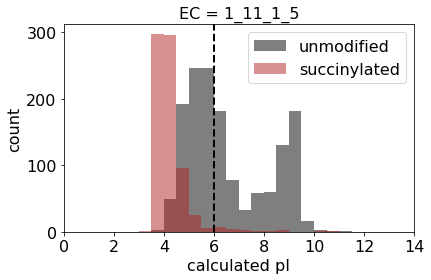

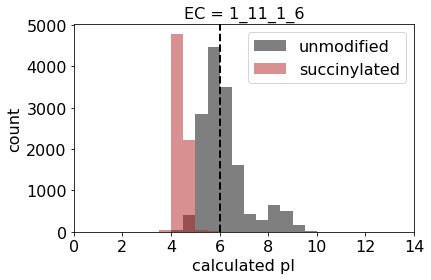

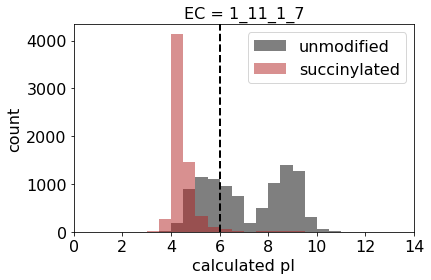

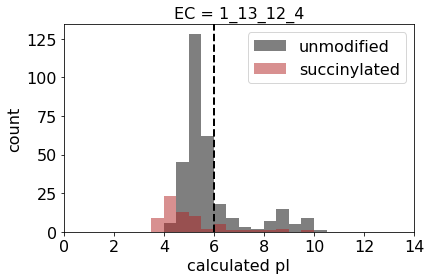

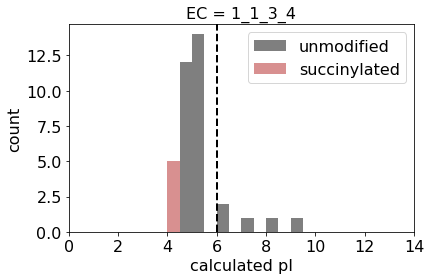

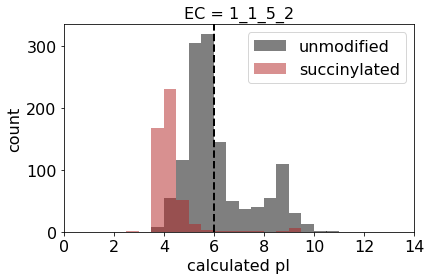

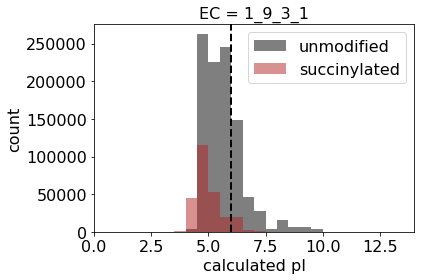

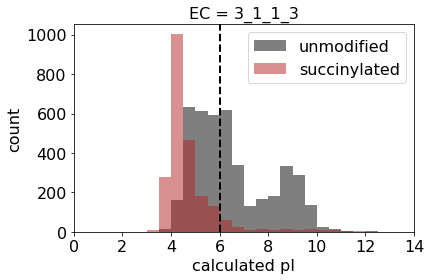

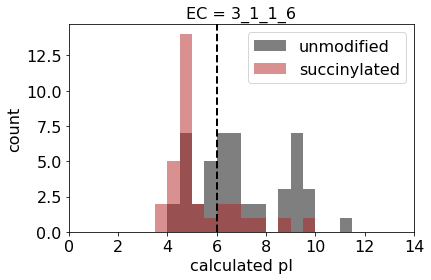

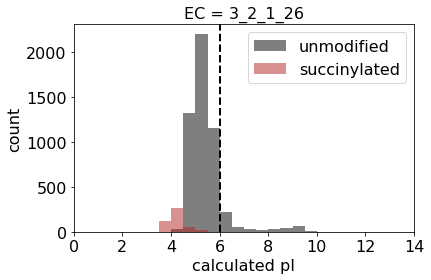

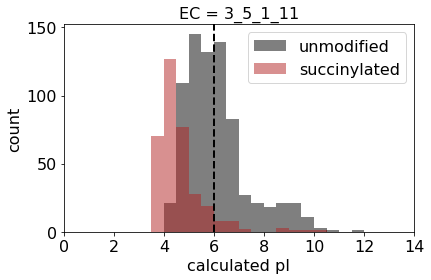

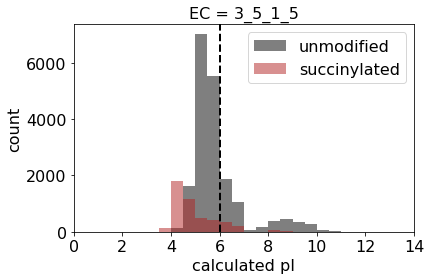

In [9]:
print('calculate all pIs for target EC sequences')
for EC_file in database_names:
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    if redo_pi is True:
        pi_fn.calculate_pI_from_file(file_mod, param_dict, output_dir)
    print('plot distribution of pIs')
    pi_data = pd.read_csv(output_dir+param_dict['out_CSV_pi'], index_col=False)
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    pi_fn.plot_EC_pI_dist(EC_pi_data, param_dict,
                          filename=file_mod.replace('.fasta', '.pdf'),
                          title=file_mod.replace(output_dir, '').replace('__BRENDA_sequences_mod.fasta', ''))
    print('done')

# Collect pI of species used in Literature data base using BRENDA

In [11]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/sequence_db/bio_min_dataset/'
output_dir = database_directory

In [12]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_set = {
    # EC : species list
    '1.11.1.5': ['equus caballus', ],
    '1.11.1.6': ['bos taurus', ],
    '1.11.1.7': ['armoracia rusticana', ],
    '1.9.3.1': ['equus caballus', ],
    '1.1.5.2': ['none', ],
    '3.5.1.5': ['canavalia ensiformis'],
    '1.1.3.4': ['aspergillus niger'],
    '1.13.12.4': ['none'],
    '3.2.1.26': ['none'],
    '3.1.1.3': ['thermomyces lanuginosus', 'alcaligenes sp.',
                'pseudomonas fluorescens',
                'rhizomucor miehei', 'candida antarctica',
                'aspergillus niger'],
    '3.1.1.6': ['lactobacillus acidophilus'],
    '3.5.1.11': ['none'],
    }

In [13]:
# read in pI output file
pi_data = pd.read_csv(output_dir+param_dict['out_CSV_pi'], index_col=False)

In [14]:
print('Screen all Enzymes in EC Classes using BRENDA data')
count_done = 0
total_start_time = time.time()
for EC_file in database_names:
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('-----------------------------------------------')
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    # only keep those that pass the pI test
    pi_passed_data = EC_pi_data[EC_pi_data['pi'] < param_dict['cutoff_pi']]
    print('--- ', 
          len(pi_passed_data), 'proteins out of', len(EC_pi_data), 
          'remain, OR', int(len(pi_passed_data)/len(EC_pi_data)*100),
          "% ---")
    EC_no = list(set(EC_pi_data['EC.code']))[0].replace(' ', '').replace(".", "_")
    print('EC:', EC_no.replace("_", "."))
    br_datafile = 'brenda_download_'+EC_no+'.txt'
    # convert br_datafile into dictionary
    br_symbols, br_data = brenda_IO.get_brenda_dict(param_dict['BRENDA_DB_loc']+br_datafile)
    # from here is quite bio-min assay literature specific - although the code can be reused
    # get species of interest from known EC records
    species_of_interest = EC_set[EC_no.replace('_', '.')]
    for spec in species_of_interest:
        print('species:', spec)
        # is species in sequence data?
        spec_in_seq, spec_in_br = brenda_IO.is_species_reported(spec, 
                                                                EC_pi_data, 
                                                                br_data, 
                                                                verbose=True)
        PR_of_int = []
        for i in sorted(br_data['PR']):
            if spec in i.lower():
                # this assumes that the first item of each line is always "#"
                PR_info = i.split("#")[1]            
                if PR_info not in PR_of_int:
                    PR_of_int.append(PR_info)
        # get pI from BRENDA
        prop_of_int = 'PI'
        list_of_int = br_data[prop_of_int]
        # get list of protein codes with property of interest
        EC_prop_PR_codes = brenda_IO.get_prop_PR_codes(list_of_int)
        value_of_int = {}
        for PR in PR_of_int:
            if PR in set([j for i in EC_prop_PR_codes.values() for j in i ]):
                print('protein code:', PR, 'has', prop_of_int, 'in BRENDA')
            else:
                print('protein code:', PR, 'does not have', prop_of_int, 'in BRENDA')
            values = [list_of_int[i].split(" ")[1] 
                      for i in EC_prop_PR_codes.keys() if PR in EC_prop_PR_codes[i]]
            # apply property specific rules
            # check for ranges - append min and max
            values_min = [i.split('-')[0] for i in values if '-' in i and i[0] != '-']
            values_max = [i.split('-')[1] for i in values if '-' in i and i[0] != '-']
            if len(values_min) > 0 and len(values_max) > 0:
                for i in np.arange(len(values)-1, -1, -1):
                    if '-' in values[i]:
                        del values[i]
                print(values_min, values_max)
                values.append(values_min[0])
                values.append(values_max[0])
            # PI == float
            values = [float(i) for i in values]
            # PI => between 0 and 14
            values = [i for i in values if i >= 0 and i <= 14]
            if len(values) > 0:
                value_of_int[PR] = values
        print('reported pIs in BRENDA:', value_of_int.values())
    count_done += 1
print('--- finished %s EC classes in %s seconds ---' % (count_done, '{0:.2f}'.format(time.time() - total_start_time)))

Screen all Enzymes in EC Classes using BRENDA data
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_5__BRENDA_sequences.fasta
---  1459 proteins out of 2220 remain, OR 65 % ---
EC: 1.11.1.5
species: equus caballus
species in sequence data: False
species in BRENDA data: False
reported pIs in BRENDA: dict_values([])
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_6__BRENDA_sequences.fasta
---  14865 proteins out of 22068 remain, OR 67 % ---
EC: 1.11.1.6
species: bos taurus
species in sequence data: True
species in BRENDA data: True
protein code: 12 has PI in BRENDA
protein code: 138 does not have PI in BRENDA
reported pIs in BRENDA: dict_values([[5.4]])
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta
---  9633 proteins out of 16288 remain, OR 59 % ---
EC: 1.11.1.7
species: armoracia rus

# From the list of reactions reported in the literature - determine, which molecules fit in ZIF-8

In [3]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])


def define_parity_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


In [4]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_mol_set = {
    # EC : species list : unique molecules
    '1.11.1.5': {'equus caballus': [
        ('hydrogen peroxide', 'OO'),
        ('pyrogallol', 'C1=CC(=C(C(=C1)O)O)O'),
        ('purporogallin', 'C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O'),
    ]},
    '1.11.1.6': {'bos taurus': [
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('3-amino-1,2,4-triazole', 'C1=NNC(=N1)N'),
    ]},
    '1.11.1.7': {'armoracia rusticana': [
        ('pyrogallol', 'C1=CC(=C(C(=C1)O)O)O'),
        ('purporogallin', 'C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O'),
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('ABTS', 'CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC'),
    ]},
    '1.9.3.1': {'equus caballus': [
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('ABTS', 'CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC'),
        ('Amplex Red', 'CC(=O)N1C2=C(C=C(C=C2)O)OC3=C1C=CC(=C3)O'),
        ('resorufin', 'C1=CC2=C(C=C1O)OC3=CC(=O)C=CC3=N2'),
        ('methyl ethyl ketone peroxide', 'CCC(C)(OO)OOC(C)(CC)OO'),
        ('tert-butyl hydroperoxide', 'CC(C)(C)OO'),
    ]},
    '1.1.5.2': {'none': [
        ('methosulfate', 'COS(=O)(=O)[O-]'),
        ('5-Methylphenazin-5-ium', 'C[N+]1=C2C=CC=CC2=NC3=CC=CC=C31'),
        ('2,6-dichloroindophenol', 'C1=CC(=O)C=CC1=NC2=CC(=C(C(=C2)Cl)O)Cl'),
    ]},
    '3.5.1.5': {'canavalia ensiformis': [
        ('Urea', 'C(=O)(N)N'),
        ('water', 'O'),
        ('carbon dioxide', 'C(=O)=O'),
        ('ammonia', 'N'),
    ]},
    '1.1.3.4': {'aspergillus niger': [
        ('D-glucose (chain)', 'C(C(C(C(C(C=O)O)O)O)O)O'),
        ('D-glucose (ring)', 'C(C1C(C(C(C(O1)O)O)O)O)O'),
        ('gluconic acid', 'C(C(C(C(C(C(=O)O)O)O)O)O)O'),
        ('hydrogen peroxide', 'OO'),
        ('Gluconolactone', 'C(C1C(C(C(C(=O)O1)O)O)O)O'),
    ]},
    '1.13.12.4': {'none': [
        ('hydrogen peroxide', 'OO'),
        ('pyruvate', 'CC(=O)C(=O)[O-]'),
        ('L-lactate', 'CC(C(=O)[O-])[O-]'),
        
    ]},
    '3.2.1.26': {'none': [
        ('sucrose', 'C(C1C(C(C(C(O1)OC2(C(C(C(O2)CO)O)O)CO)O)O)O)O'),
        ('L-fructose', 'C(C(C(C(C(=O)CO)O)O)O)O'),
        ('D-fructose', 'C1C(C(C(C(O1)(CO)O)O)O)O'),
    ]},
    '3.1.1.3': {'thermomyces lanuginosus': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'alcaligenes sp.': [  # not sure about this one - the kinetic resolution may not belong to this enyzme?
                    ('2-octanol', 'CCCCCCC(C)O'),
                    ('vinyl acetate', 'CC(=O)OC=C'),
                    ('octyl acetate', 'CCCCCCCCOC(=O)C'),
                    ('p-nitrophenyl', 'C1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('p-nitrophenyl octanoate', 'CCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('octanoic acid', 'CCCCCCCC(=O)O'),
                ],
                'pseudomonas fluorescens': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'rhizomucor miehei': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ], 
                'candida antarctica': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'aspergillus niger': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl acetate', 'CC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('acetic acid', 'CC(=O)O'),
                ]},
    '3.1.1.6': {'lactobacillus acidophilus': [
        ('p-nitrophenyl', 'C1=CC=C(C=C1)[N+](=O)[O-]'),
        ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
        ('p-nitrophenyl acetate', 'CC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('acetic acid', 'CC(=O)O'),
        ('p-nitrophenyl phosphate', 'C1=CC(=CC=C1[N+](=O)[O-])OP(=O)(O)O'),
        ('phosphate acid', 'OP(=O)([O-])[O-]'),
        ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('butyric acid', 'CCCC(=O)O'),
        ('p-nitrophenyl hexanoate', 'CCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('hexanoic acid', 'CCCCCC(=O)O'),
        ('p-nitrophenyl octanoate', 'CCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('octanoic acid', 'CCCCCCCC(=O)O'),
        ('p-nitrophenyl decanoate', 'CCCCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('decanoic acid', 'CCCCCCCCCC(=O)O'),
        ('p-nitrophenyl dodecanoate', 'CCCCCCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('dodecanoic acid', 'CCCCCCCCCCCC(=O)O'),
    ]},
    '3.5.1.11': {'none': [
        ('penicillin-G', 'CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C'),
    ]},
    }

In [5]:
# get parameters
param_dict = parameters.get_parameters()
threshold = float(param_dict['diffuse_threshold'])
# input parameters
database_directory = '/home/atarzia/psp/screening_results/biomin_known/'
output_dir = database_directory

In [6]:
# get all unique molecules and draw 2D structures
molecules = {}
diameters = {}
for i in EC_mol_set.keys():
    for j in EC_mol_set[i].keys():
        for mol in EC_mol_set[i][j]:
            molecules[mol[0]] = mol[1]
            diameters[mol[0]] = 0
            rdkit_functions.draw_smiles_to_svg(mol[1], output_dir+mol[0].replace(' ', '_')+'_2d.svg')

#### calculate size

In [8]:
rdkit_functions.calc_molecule_diameters(molecules,
                                        out_dir=output_dir, vdwScale=0.8, boxMargin=4.0,
                                        spacing=0.6, show_vdw=False, plot_ellip=False,
                                        N_conformers=50, MW_thresh=2000)

molecule: hydrogen peroxide : SMILES: OO
1 out of 46 done
molecule: pyrogallol : SMILES: C1=CC(=C(C(=C1)O)O)O
2 out of 46 done
molecule: purporogallin : SMILES: C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O
3 out of 46 done
molecule: water : SMILES: O
4 out of 46 done
molecule: oxygen : SMILES: O=O
5 out of 46 done
molecule: 3-amino-1,2,4-triazole : SMILES: C1=NNC(=N1)N
6 out of 46 done
molecule: ABTS : SMILES: CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC
7 out of 46 done
molecule: Amplex Red : SMILES: CC(=O)N1C2=C(C=C(C=C2)O)OC3=C1C=CC(=C3)O
8 out of 46 done
molecule: resorufin : SMILES: C1=CC2=C(C=C1O)OC3=CC(=O)C=CC3=N2
9 out of 46 done
molecule: methyl ethyl ketone peroxide : SMILES: CCC(C)(OO)OOC(C)(CC)OO
10 out of 46 done
molecule: tert-butyl hydroperoxide : SMILES: CC(C)(C)OO
11 out of 46 done
molecule: methosulfate : SMILES: COS(=O)(=O)[O-]
12 out of 46 done
molecule: 5-Methylphenazin-5-ium : SMILES: C[N+]1=C2C=CC=CC2=NC3=CC=CC=C31
13 out of 46 done
molecu

#### get results

In [9]:
threshold = float(param_dict['diffuse_threshold'])
diffuse = {}
no_diffuse = {}
count = 0
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    count += 1
    results = pd.read_csv(out_file)
    min_diam = min(results['diam1'])
    mid_diam = min(results['diam2'])
    # print(min(results['diam1']))
    # print(min(results['diam2']))
    # plt.hist(results['diam1'], facecolor='k', alpha=0.4)
    # plt.hist(results['diam2'], facecolor='r', alpha=0.4)
    if mid_diam <= threshold:
        print(name+':')
        print('can diffuse')
        print('min diameter =', round(min_diam, 3), 'angstrom')
        print('mid diameter =', round(mid_diam, 3), 'angstrom')
        diffuse[name] = smile
    else:
        print(name+':')
        print('cannot diffuse')
        print('min diameter =', round(min_diam, 3), 'angstrom')
        print('mid diameter =', round(mid_diam, 3), 'angstrom')
        no_diffuse[name] = smile
    print('-')
print('analyzed ', count, 'molecules')

hydrogen peroxide:
can diffuse
min diameter = 2.767 angstrom
mid diameter = 3.16 angstrom
-
pyrogallol:
cannot diffuse
min diameter = 3.097 angstrom
mid diameter = 7.058 angstrom
-
purporogallin:
cannot diffuse
min diameter = 3.943 angstrom
mid diameter = 8.733 angstrom
-
water:
can diffuse
min diameter = 2.492 angstrom
mid diameter = 2.586 angstrom
-
oxygen:
can diffuse
min diameter = 2.841 angstrom
mid diameter = 2.9 angstrom
-
3-amino-1,2,4-triazole:
cannot diffuse
min diameter = 3.009 angstrom
mid diameter = 5.274 angstrom
-
ABTS:
cannot diffuse
min diameter = 6.273 angstrom
mid diameter = 9.03 angstrom
-
Amplex Red:
cannot diffuse
min diameter = 5.2 angstrom
mid diameter = 10.211 angstrom
-
resorufin:
cannot diffuse
min diameter = 3.366 angstrom
mid diameter = 7.069 angstrom
-
methyl ethyl ketone peroxide:
cannot diffuse
min diameter = 5.667 angstrom
mid diameter = 6.93 angstrom
-
tert-butyl hydroperoxide:
cannot diffuse
min diameter = 5.344 angstrom
mid diameter = 5.69 angstrom
-

#### Plot categorical scatter plot

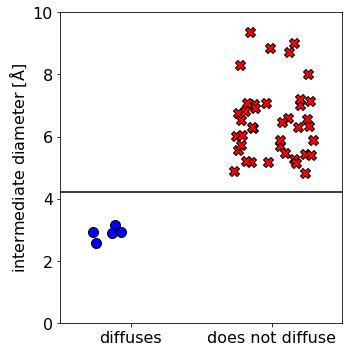

In [10]:
threshold = float(param_dict['diffuse_threshold'])
dx = 0.15
fig, ax = plt.subplots(figsize=(5,5))
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    mid_diam = min(results['diam2'])
    if mid_diam <= threshold:
        C = 'b'
        M = 'o'
        E = 'k'
        D = 0.25
    else:
        C = 'r'
        M = 'X'
        E = 'k'
        D = 0.75
    ax.scatter(D+(dx*(np.random.random() - 0.5) * 2),
               mid_diam, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
ax.axhline(y=threshold, c='k')
define_plot_variables(ax,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"categorical.pdf", dpi=720,
            bbox_inches='tight')

#### Plot shapes

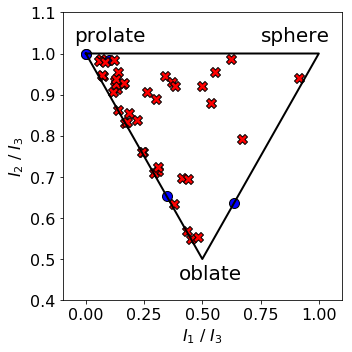

In [11]:
threshold = float(param_dict['diffuse_threshold'])
fig, ax = plt.subplots(figsize=(5,5))
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    mid_diam = min(results['diam2'])
    if mid_diam <= threshold:
        C = 'b'
        M = 'o'
        E = 'k'
        D = 0.25
    else:
        C = 'r'
        M = 'X'
        E = 'k'
        D = 0.75
    ax.scatter(np.average(results['ratio_1']),
               np.average(results['ratio_2']),
               c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
ax.plot([0, 0.5, 1, 0], [1, 0.5, 1, 1], c='k', lw=2)
ax.text(0.75, 1.03, 'sphere', fontsize=20)
ax.text(0.4, 0.45, 'oblate', fontsize=20)
ax.text(-0.05, 1.03, 'prolate', fontsize=20)
define_parity_plot_variables(ax,
                             title='',
                             xtitle='$I_1$ / $I_3$',
                             ytitle='$I_2$ / $I_3$',
                             xlim=(-0.1, 1.1),
                             ylim=(0.4, 1.1))
fig.tight_layout()
fig.savefig(output_dir+"shape.pdf", dpi=720,
            bbox_inches='tight')

# Collect reactant-product systems 
suggest new reactions!

### Collect all reaction systems from multiple databases
Online.

In [4]:
# set output directory
output_dir = '/home/atarzia/psp/screening_results/biomin_search/'

# set databases to search to collect reaction systems
# BKMS should always be last as the culmination of all DBs
Databases = ['BRENDA', 'SABIO', 'KEGG', 'BKMS', ]

# set EC numbers of interest
EC_int = ['1.11.1.5', '1.11.1.6', '1.11.1.7', '1.9.3.1',
          '1.1.5.2', '3.5.1.5', '1.1.3.4', '1.13.12.4',
          '3.2.1.26', '3.1.1.3', '3.1.1.6', '3.5.1.11']

# csv file with molecular output
mol_output_file = output_dir+'screening_output.csv'
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

In [6]:
for DB in Databases:
    # get database specific information
    DB_prop = DB_functions.get_DB_prop(DB)
    db_dir = DB_prop[0]
    # iterate over EC numbers of interest
    for EC in EC_int:
        rxn_syst.get_reaction_systems(EC, DB, output_dir, clean_system=False)

DB: BRENDA - EC: 1.11.1.5 - DB ID: BR1 - 0 of 43
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR2 - 1 of 43
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR3 - 2 of 43
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR4 - 3 of 43
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR5 - 4 of 43
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR6 - 5 of 43
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR7 - 6 of 43
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR8 - 7 of 43
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR9 - 8 of 4

RDKit WARNING: [08:01:33]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR2 - 1 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR3 - 2 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR4 - 3 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR5 - 4 of 42
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR6 - 5 of 42
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR7 - 6 of 42
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR8 - 7 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR9 - 8 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR10 - 9 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR11 - 10 of 42
skip

RDKit WARNING: [08:01:43]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR32 - 31 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR33 - 32 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR34 - 33 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR35 - 34 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR36 - 35 of 42


RDKit WARNING: [08:01:44]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR37 - 36 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR38 - 37 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR39 - 38 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR40 - 39 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR41 - 40 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR42 - 41 of 42
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR1 - 0 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR2 - 1 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR3 - 2 of 270
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR4 - 3

no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR108 - 107 of 270
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR109 - 108 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR110 - 109 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR111 - 110 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR112 - 111 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR113 - 112 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR114 - 113 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR115 - 114 of 270
skip? True
-

no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR203 - 202 of 270
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR204 - 203 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR205 - 204 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR206 - 205 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR207 - 206 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR208 - 207 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR209 - 208 of 270
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR210 - 209 of 270
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR211 - 210 of 270

no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR9 - 8 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR10 - 9 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR11 - 10 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR12 - 11 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR13 - 12 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR14 - 13 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR15 - 14 of 55
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR16 - 15 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR17 - 16 of 55
no match in DB
search PUBCHEM
no match i

RDKit WARNING: [08:06:34]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR44 - 43 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR45 - 44 of 55
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR46 - 45 of 55


RDKit WARNING: [08:06:42]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR47 - 46 of 55


RDKit WARNING: [08:06:47]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR48 - 47 of 55
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR49 - 48 of 55
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR50 - 49 of 55
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR51 - 50 of 55
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR52 - 51 of 55


RDKit WARNING: [08:07:14]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR53 - 52 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR54 - 53 of 55
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR55 - 54 of 55
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR1 - 0 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR2 - 1 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR3 - 2 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR4 - 3 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR5 - 4 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR6 - 5 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 

RDKit ERROR: [08:08:57]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM


RDKit ERROR: [08:08:59]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR35 - 34 of 128
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR36 - 35 of 128
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR37 - 36 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR38 - 37 of 128
no match in DB
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR39 - 38 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR40 - 39 of 128
skip? True
-------------------------

RDKit ERROR: [08:09:36]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM


RDKit ERROR: [08:09:38]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR47 - 46 of 128
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM


RDKit ERROR: [08:09:46]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM


RDKit ERROR: [08:09:47]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR48 - 47 of 128
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM


RDKit ERROR: [08:09:55]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM


RDKit ERROR: [08:09:57]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR49 - 48 of 128
no match in DB
search PUBCHEM


RDKit ERROR: [08:10:03]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM


RDKit ERROR: [08:10:10]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR50 - 49 of 128
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR51 - 50 of 128
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR52 - 51 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR53 - 52 of 128
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR54 - 53 of 128
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR55 - 54 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR56 - 

no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR97 - 96 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR98 - 97 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR99 - 98 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR100 - 99 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR101 - 100 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR102 - 101 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR103 - 102 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR104 - 103 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR105 - 104 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB 

RDKit ERROR: [08:13:57]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM


RDKit ERROR: [08:14:01]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR125 - 124 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR126 - 125 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR127 - 126 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR128 - 127 of 128
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.5 - DB ID: BR1 - 0 of 10
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.5 - DB ID: BR2 - 1 of 10
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.5 - DB ID: BR3 - 2 of 10
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.5 - DB ID: BR4 - 3 of 10
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.5 - DB ID: BR5 - 4 of 10
no match in DB
search PUBCHE

RDKit WARNING: [08:14:31]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR5 - 4 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR6 - 5 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR7 - 6 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR8 - 7 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR9 - 8 of 76


RDKit WARNING: [08:14:39]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR10 - 9 of 76


RDKit WARNING: [08:14:41]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR11 - 10 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR12 - 11 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR13 - 12 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR14 - 13 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR15 - 14 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR16 - 15 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR17 - 16 of 76
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR18 - 17 of 76


RDKit WARNING: [08:14:49]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR19 - 18 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR20 - 19 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR21 - 20 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR22 - 21 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR23 - 22 of 76


RDKit WARNING: [08:15:11]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR24 - 23 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM


RDKit WARNING: [08:15:20]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR25 - 24 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM


RDKit WARNING: [08:15:29]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR26 - 25 of 76
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR27 - 26 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR28 - 27 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR29 - 28 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR30 - 29 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR31 - 30 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR32 - 31 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR33 - 32 of 76
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR34 - 33 of 76
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
------------------------

RDKit WARNING: [08:16:18]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR46 - 45 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR47 - 46 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR48 - 47 of 76


RDKit WARNING: [08:16:20]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR49 - 48 of 76
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM


RDKit WARNING: [08:16:27]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR50 - 49 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR51 - 50 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR52 - 51 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR53 - 52 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR54 - 53 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR55 - 54 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR56 - 55 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR57 - 56 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR58 - 57 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR59 - 58 of 76
no match in DB
search PUBCHEM

RDKit WARNING: [08:16:37]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR60 - 59 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR61 - 60 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR62 - 61 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR63 - 62 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR64 - 63 of 76
no match in DB
search PUBCHEM


RDKit WARNING: [08:16:41]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR65 - 64 of 76
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM


RDKit WARNING: [08:16:49]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR66 - 65 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR67 - 66 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR68 - 67 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR69 - 68 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR70 - 69 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR71 - 70 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR72 - 71 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR73 - 72 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR74 - 73 of 76
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR75 - 74 of 76
skip? True
------------------

RDKit WARNING: [08:16:51]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR2 - 1 of 25
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR3 - 2 of 25


RDKit WARNING: [08:17:06]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR4 - 3 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR5 - 4 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR6 - 5 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR7 - 6 of 25


RDKit WARNING: [08:17:13]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR8 - 7 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR9 - 8 of 25
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR10 - 9 of 25
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR11 - 10 of 25


RDKit WARNING: [08:17:21]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR12 - 11 of 25


RDKit WARNING: [08:17:23]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR13 - 12 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR14 - 13 of 25


RDKit WARNING: [08:17:25]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR15 - 14 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR16 - 15 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR17 - 16 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR18 - 17 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR19 - 18 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR20 - 19 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR21 - 20 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR22 - 21 of 25
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR23 - 22 of 2

RDKit ERROR: [08:19:10]  Unhandled CTAB feature: S group SRU on line: 54. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR21 - 20 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR22 - 21 of 62
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR23 - 22 of 62
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
--------------------

RDKit ERROR: [08:20:21]  Unhandled CTAB feature: S group SRU on line: 54. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR34 - 33 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR35 - 34 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR36 - 35 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR37 - 36 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR38 - 37 of 62
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR39 - 38 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR40 - 39 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR41 - 40 of 62
no match in DB
search PUBCHEM
molecule does not have recorded 

RDKit ERROR: [08:20:47]  Unhandled CTAB feature: S group SRU on line: 54. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR45 - 44 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR46 - 45 of 62


RDKit ERROR: [08:20:57]  Unhandled CTAB feature: S group SRU on line: 54. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR47 - 46 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR48 - 47 of 62
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR49 - 48 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR50 - 49 of 62


RDKit ERROR: [08:21:10]  Unhandled CTAB feature: S group SRU on line: 75. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR51 - 50 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR52 - 51 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR53 - 52 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR54 - 53 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR55 - 54 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR56 - 55 of 62


RDKit ERROR: [08:21:21]  Unhandled CTAB feature: S group SRU on line: 54. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR57 - 56 of 62
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR58 - 57 of 62
no match in DB
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR59 - 58 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR60 - 59 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR61 - 60 of 62
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - D

no match in DB
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR65 - 64 of 377
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR66 - 65 of 377
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR67 - 66 of 377
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR68 - 67 of 377
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR69 - 68 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR70 - 69 of 377
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR71 - 70 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR72 - 71 of 377
skip? True
------------------------------

no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR132 - 131 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR133 - 132 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR134 - 133 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR135 - 134 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR136 - 135 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR137 - 136 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR138 - 137 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR139 - 138 of 377
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
---------

no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR198 - 197 of 377
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR199 - 198 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR200 - 199 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR201 - 200 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR202 - 201 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR203 - 202 of 377
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------

no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR267 - 266 of 377
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR268 - 267 of 377
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR269 - 268 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR270 - 269 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR271 - 270 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR272 - 271 of 377
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR273 - 272 of 377
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
------------------

no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR332 - 331 of 377
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR333 - 332 of 377
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR334 - 333 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR335 - 334 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR336 - 335 of 377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR337 - 336 of 377
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR338 - 337 of 377
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR339 - 338 of 377
no match in DB
search PUBCHEM
skip? True
-----------------------------------


skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR24 - 23 of 129
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR25 - 24 of 129
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR26 - 25 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR27 - 26 of 129
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR28 - 27 of 129
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR29 - 28 of 129
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR30 - 29 of 129
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR31 - 30 of 129
n

skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR85 - 84 of 129
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR86 - 85 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR87 - 86 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR88 - 87 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR89 - 88 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR90 - 89 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR91 - 90 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR92 - 91 of 129
skip? True
---------------------------------

RDKit ERROR: [08:45:01]  Unhandled CTAB feature: S group SRU on line: 75. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR124 - 123 of 129
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM


RDKit ERROR: [08:45:11]  Unhandled CTAB feature: S group SRU on line: 27. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR125 - 124 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR126 - 125 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR127 - 126 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR128 - 127 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR129 - 128 of 129
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR1 - 0 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR2 - 1 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR3 - 2 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BREND

RDKit WARNING: [08:45:22]  S group SUP ignored on line 37
RDKit WARNING: [08:45:22]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR5 - 4 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR6 - 5 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR7 - 6 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR8 - 7 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR9 - 8 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR10 - 9 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR11 - 10 of 214


RDKit WARNING: [08:45:38]  S group SUP ignored on line 37
RDKit WARNING: [08:45:38]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR12 - 11 of 214


RDKit WARNING: [08:45:41]  S group SUP ignored on line 37
RDKit WARNING: [08:45:41]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR13 - 12 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR14 - 13 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR15 - 14 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR16 - 15 of 214
no match in DB
search PUBCHEM


RDKit WARNING: [08:45:46]  S group SUP ignored on line 37
RDKit WARNING: [08:45:46]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR17 - 16 of 214
no match in DB
search PUBCHEM


RDKit WARNING: [08:45:57]  S group SUP ignored on line 37
RDKit WARNING: [08:45:57]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR18 - 17 of 214


RDKit WARNING: [08:45:59]  S group SUP ignored on line 37
RDKit WARNING: [08:45:59]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR19 - 18 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR20 - 19 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR21 - 20 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR22 - 21 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR23 - 22 of 214
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR24 - 23 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR

RDKit WARNING: [08:49:00]  S group SUP ignored on line 37
RDKit WARNING: [08:49:00]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR57 - 56 of 214


RDKit WARNING: [08:49:01]  S group SUP ignored on line 37
RDKit WARNING: [08:49:01]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR58 - 57 of 214


RDKit WARNING: [08:49:03]  S group SUP ignored on line 37
RDKit WARNING: [08:49:03]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR59 - 58 of 214
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR60 - 59 of 214
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR61 - 60 of 214
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR62 - 61 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR63 - 62 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR64 - 63 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR65 - 64 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR66 - 65 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR67 - 66 of

RDKit WARNING: [08:49:19]  S group SUP ignored on line 37
RDKit WARNING: [08:49:19]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR71 - 70 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR72 - 71 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR73 - 72 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR74 - 73 of 214
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR75 - 74 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR76 - 75 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR77 - 76 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3

no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR135 - 134 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR136 - 135 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR137 - 136 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR138 - 137 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR139 - 138 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR140 - 139 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 

RDKit WARNING: [08:53:39]  S group SUP ignored on line 37
RDKit WARNING: [08:53:39]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR160 - 159 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR161 - 160 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR162 - 161 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR163 - 162 of 214
no match in DB
search PUBCHEM


RDKit WARNING: [08:54:01]  S group SUP ignored on line 37
RDKit WARNING: [08:54:01]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR164 - 163 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR165 - 164 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR166 - 165 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR167 - 166 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR168 - 167 of 214
no match in DB
search PUBCHEM


RDKit WARNING: [08:54:14]  S group SUP ignored on line 37
RDKit WARNING: [08:54:14]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR169 - 168 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR170 - 169 of 214
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR171 - 170 of 214
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR172 - 171 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR173 - 172 of 214
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR174 - 173 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR175 - 174 of 214
no match in DB
search PUBCHEM
no match in DB
search PUBCHEM
skip? True
----------

RDKit WARNING: [08:56:50]  S group SUP ignored on line 37
RDKit WARNING: [08:56:50]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR214 - 213 of 214


RDKit WARNING: [08:56:51]  S group SUP ignored on line 37
RDKit WARNING: [08:56:51]  S group SUP ignored on line 37


skip? False
-----------------------------------
39 matching entries found.
DB: SABIO - EC: 1.11.1.5 - DB ID: 23571 - 0 of 39
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23572 - 1 of 39
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23573 - 2 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23574 - 3 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23575 - 4 of 39
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23576 - 5 of 39
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23577 - 6 of 39
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23578 - 7 of 39
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23579 - 8 of 39
search 

-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44728 - 44 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44729 - 45 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44730 - 46 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44731 - 47 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44732 - 48 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44733 - 49 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44734 - 50 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44735 - 51 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44736 - 52 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44737 - 53 of 127
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44738 - 54 of 127
--------------------------------

-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2034 - 10 of 67
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2035 - 11 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2036 - 12 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2218 - 13 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2219 - 14 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2220 - 15 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2221 - 16 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 225 - 17 of 67
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 226 - 18 of 67
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 227 - 19 of 67
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 1

-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38312 - 12 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38313 - 13 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38314 - 14 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38315 - 15 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38316 - 16 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38317 - 17 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38318 - 18 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38319 - 19 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38320 - 20 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38321 - 21 of 41
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38322 - 22 of 41
-----------------------------------
DB: SABIO - EC: 3.

-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 36087 - 9 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 36088 - 10 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37083 - 11 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37084 - 12 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37085 - 13 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37086 - 14 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37087 - 15 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37088 - 16 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37089 - 17 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37090 - 18 of 79
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37091 - 19 of 79
-----------------------------------
DB: SABI

search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 48403 - 23 of 72
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 48404 - 24 of 72
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 48405 - 25 of 72
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 48406 - 26 of 72
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 48407 - 27 of 72
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 48408 - 28 of 72
search PUBCHEM
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 49698 - 29 of 72
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 49699 - 30 of 72
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 497

search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11630 - 28 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11631 - 29 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11632 - 30 of 64
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11633 - 31 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11634 - 32 of 64
search PUBCHEM
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14939 - 33 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14940 - 34 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14941 - 35 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14942 - 36 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14943 - 37 of 64
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14944 - 38 of 6

RDKit WARNING: [09:15:20] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [09:15:27] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [09:15:33] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [09:16:48] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [09:16:57] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [09:17:06] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [09:17:15] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [09:19:30] WARNING:  Problems/mismatches: Mobile-H( Proton balance: Does not match)
RDKit WARNING: [10:02:15]  S group SUP ignored on line 8


-----------------------------------
DB: KEGG - EC: 1.11.1.6 - DB ID: R00602 - 1 of 3
reaction is reversible
-----------------------------------
DB: KEGG - EC: 1.11.1.6 - DB ID: R02670 - 2 of 3
reaction is reversible


RDKit WARNING: [10:02:29]  S group SUP ignored on line 8


-----------------------------------
DB: KEGG - EC: 1.11.1.7 - DB ID: R03532 - 0 of 6
reaction is reversible
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
-----------------------------------
DB: KEGG - EC: 1.11.1.7 - DB ID: R00602 - 1 of 6
reaction is reversible
-----------------------------------
DB: KEGG - EC: 1.11.1.7 - DB ID: R02596 - 2 of 6
reaction is reversible
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
-----------------------------------
DB: KEGG - EC: 1.11.1.7 - DB ID: R03919 - 3 of 6
reaction is reversible
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
-----------------------------------
DB: KEGG - EC: 1.11.1.7 - DB ID: R04007 - 4 of 6
reaction is reversible
CHEBI ID not available - skipping whole reaction.
-----------------------------------
DB: KEGG - EC: 1.11.1.7 - DB ID: R07443 - 5 

RDKit WARNING: [10:03:20]  S group SUP ignored on line 8


-----------------------------------
DB: KEGG - EC: 1.9.3.1 - DB ID: R00082 - 1 of 2
reaction is reversible


RDKit WARNING: [10:03:28]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
-----------------------------------
DB: KEGG - EC: 1.1.5.2 - DB ID: R06620 - 0 of 1
reaction is reversible


RDKit ERROR: [10:03:42]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM


RDKit ERROR: [10:03:44]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
-----------------------------------
DB: KEGG - EC: 3.5.1.5 - DB ID: R00131 - 0 of 2
reaction is reversible
-----------------------------------
DB: KEGG - EC: 3.5.1.5 - DB ID: R06134 - 1 of 2
reaction is reversible
-----------------------------------
DB: KEGG - EC: 1.1.3.4 - DB ID: R01522 - 0 of 1
reaction is reversible


RDKit WARNING: [10:04:00]  S group SUP ignored on line 8


-----------------------------------
DB: KEGG - EC: 1.13.12.4 - DB ID: R00319 - 0 of 1
reaction is reversible


RDKit WARNING: [10:04:05]  S group SUP ignored on line 8


-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R00801 - 0 of 9
reaction is reversible
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R00802 - 1 of 9
reaction is reversible
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R02410 - 2 of 9
reaction is reversible
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R03635 - 3 of 9
reaction is reversible
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R03921 - 4 of 9
reaction is reversible
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
--------------------

RDKit WARNING: [10:06:12]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.11.1.6 - DB ID: 2570 - 1 of 5
NADH 16908
H+ 15378
O2 15379
NAD+ 15846
H2O2 16240


RDKit WARNING: [10:06:14]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.11.1.6 - DB ID: 8219 - 2 of 5
H2O2 16240
methanol 17790
formaldehyde 16842
H2O 15377
-----------------------------------
DB: BKMS - EC: 1.11.1.6 - DB ID: 16541 - 3 of 5
reaction is reversible
3-Hydroxyanthranilate 36559
Oxygen 15379
Cinnavalininate 3715
O2.- 18421
Hydrogen peroxide 16240
H+ 15378


RDKit WARNING: [10:06:17]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.11.1.6 - DB ID: 27391 - 4 of 5
ethanol 16236
hydrogen peroxide 16240
H2O 15377
acetaldehyde 15343
-----------------------------------
DB: BKMS - EC: 1.11.1.7 - DB ID: 8220 - 0 of 15
H2O2 16240
methanol 17790
formaldehyde 16842
H2O 15377
-----------------------------------
DB: BKMS - EC: 1.11.1.7 - DB ID: 9909 - 1 of 15
DB: BKMS - EC: 1.11.1.7 - DB ID: 11029 - 2 of 15
ascorbate 22651
H2O2 16240
dehydroascorbate 17242
H2O 15377
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
-----------------------------------
DB: BKMS - EC: 1.11.1.7 - DB ID: 16531 - 3 of 15
DB: BKMS - EC: 1.11.1.7 - DB ID: 16751 - 4 of 15
reaction is reversible
skipping this molecule because it contains:  lignin
Sinapyl alcohol 28813
Syringyl lignin 64476
-----------------------------------
DB: BKMS - EC: 1.11.1.7 - DB ID: 16770 - 5 of 15
reaction is reversible
skipping this molecule because it contains:  l

RDKit WARNING: [10:06:45]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.9.3.1 - DB ID: 16228 - 1 of 5
reaction is reversible
Oxygen 15379
Ferrocytochrome c2 16707
Ferricytochrome c2 16448
H2O 15377


RDKit WARNING: [10:06:48]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
-----------------------------------
DB: BKMS - EC: 1.9.3.1 - DB ID: 20405 - 2 of 5
DB: BKMS - EC: 1.9.3.1 - DB ID: 23403 - 3 of 5
DB: BKMS - EC: 1.9.3.1 - DB ID: 55972 - 4 of 5
no match in DB
ferrocytochrome c(H) None
O2 15379
no match in DB
ferricytochrome c(H) None
H2O 15377
-----------------------------------
DB: BKMS - EC: 1.1.5.2 - DB ID: 10094 - 0 of 2
D-glucose 17634
ubiquinone 16389
D-glucono-1,5-lactone 16217
ubiquinol 17976
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM


RDKit ERROR: [10:07:09]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM


RDKit ERROR: [10:07:11]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
-----------------------------------
DB: BKMS - EC: 1.1.5.2 - DB ID: 42759 - 1 of 2
D-glucose 17634
pyrroloquinoline quinone 18315
D-glucono-1,5-lactone 16217
pyrroloquinoline quinol 18356
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
-----------------------------------
DB: BKMS - EC: 3.5.1.5 - DB ID: 496 - 0 of 2
a monocarboxylic acid amide 83628
H2O 15377
a monocarboxylate 35757
NH3 16134
-----------------------------------
DB: BKMS - EC: 3.5.1.5 - DB ID: 500 - 1 of 2
urea 16199
H2O 15377
CO2 16526
NH3 16134
-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 1223 - 0 of 7
beta-D-glucose 15903
O2 15379
D-glucono-1,5-lactone 16217
H2O2 16240


RDKit WARNING: [10:07:26]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 1474 - 1 of 7
D-glucose 17634
acceptor 15339
D-glucono-1,5-lactone 16217
reduced acceptor 17499
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 1646 - 2 of 7
L-sorbose 17266
O2 15379
5-dehydro-D-fructose 17011
H2O2 16240
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM


RDKit WARNING: [10:07:46]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 6736 - 3 of 7
D-mannose 16024
O2 15379
no match in DB
D-mannono-1,5-lactone None
H2O2 16240
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM


RDKit WARNING: [10:07:56]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 6739 - 4 of 7
2-deoxy-D-glucose 15866
O2 15379
2-deoxy-D-glucono-1,5-lactone 57245
H2O2 16240
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM


RDKit WARNING: [10:08:03]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 14182 - 5 of 7
D-xylose 65327
O2 15379
D-xylosone 46675
H2O2 16240
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM


RDKit WARNING: [10:08:10]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 16199 - 6 of 7
reaction is reversible
2-Dehydro-D-glucose 16609
Oxygen 15379
2-Dehydro-D-glucono-1,5-lactone 27583
Hydrogen peroxide 16240


RDKit WARNING: [10:08:11]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
-----------------------------------
DB: BKMS - EC: 1.13.12.4 - DB ID: 2130 - 0 of 2
(S)-lactate 16651
O2 15379
acetate 30089
CO2 16526
H2O 15377


RDKit WARNING: [10:08:18]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.13.12.4 - DB ID: 10874 - 1 of 2
(S)-malate 15589
O2 15379
oxaloacetate 25733
H2O2 16240


RDKit WARNING: [10:08:20]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 10395 - 0 of 11
no match in DB
beta-D-fructofuranosyl 6-O-phosphono-alpha-D-glucopyranoside None
H2O 15377
no match in DB
alpha-D-glucopyranosyl 6-phosphate None
beta-D-fructofuranose 28645
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 11007 - 1 of 11
sucrose 17992
H2O 15377
D-fructose 15824
alpha-D-glucose 17925
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 11280 - 2 of 11
sucrose 6-phosphate 16308
H2O 15377
D-glucose 6-phosphate 14314
D-fructose 15824
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
se

-----------------------------------
DB: BKMS - EC: 3.5.1.11 - DB ID: 32461 - 3 of 6
penicillin V 27446
H2O 15377
6-aminopenicillanic acid 16705
phenoxyacetic acid 8075


RDKit WARNING: [10:11:27]  S group SUP ignored on line 37
RDKit WARNING: [10:11:27]  S group SUP ignored on line 37


-----------------------------------
DB: BKMS - EC: 3.5.1.11 - DB ID: 62670 - 4 of 6
DB: BKMS - EC: 3.5.1.11 - DB ID: 65240 - 5 of 6
cephalexin 3534
H2O 15377
no match in DB
(2R)-2-[(R)-[[(2R)-2-amino-2-phenylacetyl]amino](carboxy)methyl]-5-methyl-3,6-dihydro-2H-1,3-thiazine-4-carboxylic acid None
-----------------------------------


In [7]:
# what percentage of reaction systems have skip_rxn = False
count = 0
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is False:
        count += 1
        
print('-----------------------------------')
print(count, 'reaction systems of', len(react_syst_files), 'are NOT skipped.')
print('=>', round(count/len(react_syst_files), 4)*100, 'percent')
print('-----------------------------------')

-----------------------------------
993 reaction systems of 2097 are NOT skipped.
=> 47.349999999999994 percent
-----------------------------------


### Check all reaction systems for if they fit through MOF
Not DB dependant.
Offline.

In [9]:
# get parameters
param_dict = parameters.get_parameters()
threshold = float(param_dict['diffuse_threshold'])
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

In [ ]:
# iterate over reaction system files
count = 0
for rs in rxn_syst.yield_rxn_syst(output_dir):
    print('checking rxn', count, 'of', len(react_syst_files))
    count += 1
    if rs.skip_rxn is True:
        print('skipping reaction....')
        continue
    
    # define reactants and products dict
    # name: (smile, DB, DB_ID, iupac_name, role)
    components_dict = {}
    
    # ignore any reactions with unknown components
    rs.skip_rxn = False
    for m in rs.components:
        if m.mol is None:
            rs.skip_rxn = True
    
    if rs.skip_rxn is True:
        print('skipping reaction - it is incomplete or generic')
        rs.save_object(output_dir+rs.pkl)
        continue
    for m in rs.components:
        # get IUPAC NAME
        if m.iupac_name is None:
            m.cirpy_to_iupac()
        # remove reactions with general atoms (given by '*' in SMILES)
        if "*" in m.SMILES:
            rs.skip_rxn = True
            print('skipping reaction - it is incomplete or generic')
            rs.save_object(output_dir+rs.pkl)
            break
        components_dict[m.name] = (m.SMILES, m.DB, m.DB_ID, m.iupac_name, m.role.lower())
    
    # calculate molecule size of all components
    # save to molecule output files
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    DB_functions.get_molecule_diameters(components_dict,
                                        molecule_output=molecule_output,
                                        mol_output_file=mol_output_file, out_dir=output_dir,
                                        vdwScale=0.8, boxMargin=4.0, 
                                        spacing=0.6, N_conformers=50, MW_thresh=250)
    
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    
    # get diameters (should alrady be calculated) 
    # of all components of reaction
    rs.check_all_fit(threshold, molecule_output)
    
    # ignore any reactions with components with no sizes
    for m in rs.components:
        if m.mid_diam is None or m.mid_diam == 0:
            rs.skip_rxn = True
    rs.save_object(output_dir+rs.pkl)
    print('-----------------------------------')

checking rxn 0 of 2097
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 23680
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
checking rxn 1 of 2097
-----------------------------------
checking rxn 2 of 2097
skipping reaction....
checking rxn 3 of 2097
-----------------------------------
checking rxn 4 of 2097
-----------------------------------
checking rxn 5 of 2097
skipping reaction....
checking rxn 6 of 2097
-----------------------------------
checking rxn 7 of 2097
-----------------------------------
checking rxn 8 of 2097
-----------------------------------
checking rxn 9 of 2097
skipping reaction....
checking rxn 10 of 2097
skipping reaction - it is incomplete or generic
checking rxn 11 of 2097
skipping react

-----------------------------------
checking rxn 99 of 2097
-----------------------------------
checking rxn 100 of 2097
skipping reaction....
checking rxn 101 of 2097
-----------------------------------
checking rxn 102 of 2097
-----------------------------------
checking rxn 103 of 2097
skipping reaction....
checking rxn 104 of 2097
-----------------------------------
checking rxn 105 of 2097
skipping reaction....
checking rxn 106 of 2097
skipping reaction....
checking rxn 107 of 2097
skipping reaction....
checking rxn 108 of 2097
-----------------------------------
checking rxn 109 of 2097
skipping reaction....
checking rxn 110 of 2097
skipping reaction....
checking rxn 111 of 2097
-----------------------------------
checking rxn 112 of 2097
-----------------------------------
checking rxn 113 of 2097
skipping reaction....
checking rxn 114 of 2097
skipping reaction....
checking rxn 115 of 2097
skipping reaction....
checking rxn 116 of 2097
skipping reaction....
checking rxn 117 of 2

In [ ]:
# what percentage of reaction systems have skip_rxn = False
count = 0
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is False:
        count += 1
        
print('-----------------------------------')
print(count, 'reaction systems of', len(react_syst_files), 'are NOT skipped.')
print('=>', round(count/len(react_syst_files), 4)*100, 'percent')
print('-----------------------------------')

### Get subset of reaction systems that fit, with known protein sequences and checks if MOF can be seeded
DB dependant.
Online collection of Uniprot sequence.

In [ ]:
param_dict = parameters.get_parameters()
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

In [ ]:
# iterate over reaction system files
count = 0
for rs in rxn_syst.yield_rxn_syst(output_dir):
    print('checking rxn', count, 'of', len(react_syst_files))
    count += 1
    if rs.skip_rxn is True:
        print('skipping reaction....')
        print('-----------------------------------')
        continue
    # this is only possible for reaction systems with UNIPROT ID
    if rs.UniprotID is None or rs.UniprotID == '':
        print('no sequence known')
        print('-----------------------------------')
        continue
        
    # split UniprotID for the cases where multiple subunits exist
    IDs = rs.UniprotID.split(" ")
    print('Uniprot IDs:', IDs)
    # pI already checked?
    if rs.seed_MOF is not None:
        print('-----------------------------------')
        continue
    if len(IDs) > 0:
        # iterate over all UniProtIDs
        # assume all sequences require pI < cutoff for MOF growth
        # this is done by collating all sequences
        total_sequence = ''
        for i in IDs:
            sequence = Uniprot_IO.get_sequence(i)
            total_sequence += sequence
        rs = pi_fn.calculate_rxn_syst_pI(total_sequence, rs, param_dict=param_dict)
        rs.save_object(output_dir+rs.pkl)
        print('seed MOF?', rs.seed_MOF)
    else:
        rs.save_object(output_dir+rs.pkl)
        print('seed MOF?', rs.seed_MOF)
    print('-----------------------------------')

## Output

### percentage of reaction systems with sequence data?

In [ ]:
count = 0
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')
for rs in rxn_syst.yield_rxn_syst(output_dir):
    # this is only possible for reaction systems with UNIPROT ID
    if rs.UniprotID != '':
        if rs.UniprotID != None:
            count += 1
        
print('-----------------------------------')
print(count, 'reaction systems of', len(react_syst_files), 'had a sequence.')
print('=>', round(count/len(react_syst_files), 4)*100, 'percent')
print('-----------------------------------')

### Plot distribution of all pI values for reaction systems

In [ ]:
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
native_pi = []
succ_pi = []
count = 0
for rs in rxn_syst.yield_rxn_syst(output_dir):  
    print('checking rxn', count, 'of', len(react_syst_files))
    count += 1
    # collect pIs of all sequences even if reaction is skipped elsewhere
    if rs.skip_rxn is True and rs.UniprotID != '' and rs.UniprotID != None:
        try:
            pI = rs.pI
        except AttributeError:
            print('calculating pI')
            IDs = rs.UniprotID.split(" ")
            total_sequence = ''
            for i in IDs:
                sequence = Uniprot_IO.get_sequence(i)
                total_sequence += sequence
            rs = pi_fn.calculate_rxn_syst_pI(total_sequence, rs, param_dict=param_dict)
            rs.save_object(output_dir+rs.pkl)
    
    if rs.UniprotID != '' and rs.UniprotID != None:
        if rs.req_mod == None:
            native_pi.append(rs.pI)
        else:
            succ_pi.append(rs.pI)
        
ax.hist(native_pi,
        facecolor='k',
        alpha=0.5,
        histtype='stepfilled',
        bins=np.arange(0, 14 + 0.2, 0.5),
        label='unmodified')

ax.hist(succ_pi,
        facecolor='firebrick',
        alpha=0.5,
        histtype='stepfilled',
        bins=np.arange(0, 14 + 0.2, 0.5),
        label='succinylated')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('calculated pI', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.set_xlim(0, 14)
# plot pI cut-off
ax.axvline(x=param_dict['cutoff_pi'], c='k', lw='2', linestyle='--')
# legend
ax.legend(fontsize=16)

fig.tight_layout()
fig.savefig(output_dir+"pI_dist.pdf",
            dpi=720, bbox_inches='tight')

### Plot pI vs maximum component size

In [ ]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
# iterate over reaction system files
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
        
    if rs.seed_MOF is None:
        continue
    
    if rs.all_fit is True and rs.seed_MOF is True:
        M = 'o'
        if rs.req_mod is not None:
            C = 'orange'
        else:
            C = 'b'
        E = 'k'
    else:
        #if rs.pI < 6 or rs.max_comp_size < 4.2:
        #    print(rs.seed_MOF, rs.all_fit, rs.pkl, rs.pI, rs.max_comp_size)
        #    input('done')
        M = 'o'
        C = 'r'
        E = 'k'
        
    ax.scatter(rs.pI,
               rs.max_comp_size, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
# decoy legend
ax.scatter(-100, 100,
           c='b', 
           edgecolors=E,
           marker='o', 
           alpha=1.0,
           s=100,
           label='candidate - native')
ax.scatter(-100, 100,
           c='orange',
           edgecolors=E,
           marker='o',
           alpha=1,
           s=100,
           label='candidate - modified')
ax.scatter(-100, 100,
           c='r',
           edgecolors=E,
           marker='x',
           alpha=1,
           s=100,
           label='non-candidate')

ax.legend(loc=1, fontsize=12)

ax.axhline(y=threshold, c='k')
ax.axvline(x=param_dict['cutoff_pi'], c='k')
define_plot_variables(ax,
                      title='',
                      xtitle='pI',
                      ytitle='diameter of largest component [$\mathrm{\AA}$]',
                      xlim=(0, 14),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"size_vs_pI.pdf", dpi=720,
            bbox_inches='tight')

### Plot # of reactions vs threshold value

In [ ]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
max_sizes = []
reaction_reported = [] 
# iterate over reaction system files
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
    # get list of SMILES of all components
    r_smiles = []
    r_MW = []
    for r in rs.components:
        r_smiles.append(r.SMILES)
        r_MW.append(Descriptors.MolWt(r.mol))
    r_smiles = [x for _, x in sorted(zip(r_MW, r_smiles))]
    if r_smiles in reaction_reported:
        continue
    else:
        reaction_reported.append(r_smiles)
    try:
        if rs.max_comp_size > 0:
            max_sizes.append(rs.max_comp_size)
    except AttributeError:
        pass

    
max_sizes = np.asarray(max_sizes)
counts = []
threshs = np.arange(0.1, 21, 0.5)
for thr in threshs:
    count_above = len(max_sizes[max_sizes < thr])
    counts.append(count_above)
    
ax.bar(threshs, counts, align='center', alpha=0.5, width=0.2)

ax.axvline(x=threshold, c='k')

define_plot_variables(ax,
                      title='',
                      xtitle='threshold',
                      ytitle='# reactions',
                      xlim=(0, 11),
                      ylim=(0, max(counts)+10))
fig.tight_layout()
fig.savefig(output_dir+"size_vs_threshold.pdf", dpi=720,
            bbox_inches='tight')

### Categorize all molecules in output file

In [ ]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])

In [ ]:
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

In [ ]:
dx = 0.15
fig, ax = plt.subplots(figsize=(5,5))
for idx, row in molecule_output.iterrows():
    mid_diam = row['mid_diam']
    if mid_diam == 0:
        continue
    if mid_diam <= threshold:
        M = 'o'
        E = 'k'
        D = 0.25
        print('unique molecule that fits:', row['name'], 
              '- DB:', row['DB'], '- ID:', row['DB_ID'])
    else:
        M = 'o'
        E = 'k'
        D = 0.75
    
    # set colour based on role
    if row['role'] == 'reactant':
        C = 'b'
    elif row['role'] == 'product':
        C = 'r'
    elif row['role'] == 'both':
        C = 'purple'
    
    ax.scatter(D+(dx*(np.random.random() - 0.5) * 2),
               mid_diam, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
# decoy legend
ax.scatter(-100, 100,
           c='b', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='reactant')
ax.scatter(-100, 100,
           c='r', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='product')
ax.scatter(-100, 100,
           c='purple', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='both')

ax.legend(loc=2, fontsize=12)

ax.axhline(y=threshold, c='k')
ax.axvline(x=0.5, c='k', alpha=0.3)
define_plot_variables(ax,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"categorical.pdf", dpi=720,
            bbox_inches='tight')

In [ ]:
molecule_output

### print all reactions that fit

In [ ]:
reaction_reported = []
# iterate over reaction system files
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
    # get list of SMILES of all components
    r_smiles = []
    r_MW = []
    for r in rs.components:
        r_smiles.append(r.SMILES)
        r_MW.append(Descriptors.MolWt(r.mol))
    r_smiles = [x for _, x in sorted(zip(r_MW, r_smiles))]
    if r_smiles in reaction_reported:
        continue
    else:
        reaction_reported.append(r_smiles)
    if rs.all_fit is True:
        count += 1
        print("New Reaction:")
        rs.print_rxn_system()
        
print("There are", count, "new reactions!")

## Timing Information

#### pI screening - all sequences in BRENDA

In [ ]:
times = [0.74, 8.18, 4.85, 0.13, 0.02, 0.78, 
         0.62, 7.42, 4.26, 0.11, 0.01, 0.67, 
         300.89, 1.81, 0.03, 1.82, 0.44, 5.56]
seqs = [2220, 22068, 16288, 379, 36, 1765, 2220,
        22068, 16288, 379, 36, 1765, 1253592,
        6487, 80, 5665, 1098, 23660]
plt.scatter(times, seqs, c='k')
plt.xlabel('time (s)')
plt.ylabel('no. sequences')
plt.xlim(0, 15)
plt.ylim(0, 30000)

#### molecule screening

In [ ]:
print('time taken to do molecule screening:')
print('collect reaction systems:', 1*60*60 + 47*60 + 34, 's')
print('accessibility:', 1*60*60 + 0*60 + 49, 's')
print('pI analysis:', 0*60*60 + 7*60 + 55, 's')
print('total:', 2*60*60 + 54*60 + 34 + 49 + 55, 's ==', (2*60*60 + 54*60 + 34 + 49 + 55) / 60 / 60, 'h')